<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/NEWNEW_MIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')



df = df[df['n/m']==2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] #cple
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [2]:
y_new = []
cnt0=0
cnt1=0
cnt2=0
cnt3=0
for val in y:
  if(val<10):
    y_new.append(0)
    cnt0+=1
  elif(10 <= val and val<1000):
    y_new.append(1)
    cnt1+=1
  else:
    y_new.append(2)
    cnt2+=1

cnt = 0
if(cnt0>0):
  cnt+=1
if(cnt1>0):
  cnt+=1
if(cnt2>0):
  cnt+=1
if(cnt3>0):
  cnt+=1

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)

In [3]:
names = [ 'av.length', 'n', 'std.dev', 'k', 'm', 'max']
X_modified = X.drop([   'n/m', 'indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','median', 'min', 'range'], axis = 1)
print(X_modified.head())
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(random_state=0)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)


     n    m   av.length     std.dev   max    k          y
0  120   60  301.058319  106.808502   479  106   8.401604
1  160   80   98.750000   20.846851   155   73  12.711509
2  200  100  799.424988  192.674683  1375  180   5.262224
3  160   80  429.350006  135.316574   638  127   5.486180
4  160   80   52.162498   29.158621   100   84  27.108606


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.9)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y', 'k', 'm'], axis = 1)

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y', 'k', 'm'], axis = 1)
X_test = sc.transform(X_test)

1374
153
        n   m  av.length    std.dev  max   k             y
1362   40  20  87.949997  48.465660  239  37  99999.000000
511    20  10  97.099998  42.628010  189  19      0.180378
9     180  90  61.922222  22.326036  100  72     16.009718
393    80  40  61.575001  24.449776  100  53      6.197287
471   140  70  99.842857  19.030935  146  65      8.410722


In [6]:

from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(8, input_dim = X_modified.shape[1]-3, activation='relu'))

classifier.add(Dense(12, activation = 'relu'))
classifier.add(Dropout(0.125))

#classifier.add(Dense(32, activation = 'relu'))

#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(16, activation = 'relu'))

#classifier.add(Dense(16, activation='relu'))

#classifier.add(Dense(8, activation='relu'))

#classifier.add(Dense(12, activation='relu'))

classifier.add(Dense(cnt, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 12)                108       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 39        
                                                                 
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 64, 
                    epochs = 350, shuffle = True)

Epoch 1/350
22/22 [==============================] - 2s 7ms/step - loss: 1.1570 - accuracy: 0.2817
Epoch 2/350
22/22 [==============================] - 0s 3ms/step - loss: 1.1206 - accuracy: 0.3435
Epoch 3/350
22/22 [==============================] - 0s 4ms/step - loss: 1.0704 - accuracy: 0.4432
Epoch 4/350
22/22 [==============================] - 0s 4ms/step - loss: 1.0461 - accuracy: 0.5313
Epoch 5/350
22/22 [==============================] - 0s 4ms/step - loss: 1.0233 - accuracy: 0.5590
Epoch 6/350
22/22 [==============================] - 0s 4ms/step - loss: 1.0015 - accuracy: 0.5699
Epoch 7/350
22/22 [==============================] - 0s 4ms/step - loss: 0.9750 - accuracy: 0.5655
Epoch 8/350
22/22 [==============================] - 0s 6ms/step - loss: 0.9623 - accuracy: 0.5488
Epoch 9/350
22/22 [==============================] - 0s 5ms/step - loss: 0.9442 - accuracy: 0.5539
Epoch 10/350
22/22 [==============================] - 0s 3ms/step - loss: 0.9246 - accuracy: 0.5633
Epoch 11/

accuracy: 91.50%


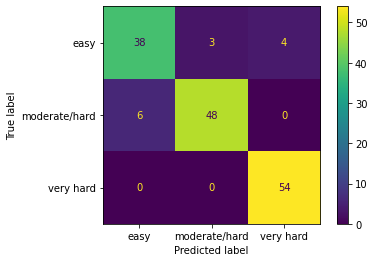

In [8]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])
cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [9]:
column_names = ['n', 'k', 'n/m', 'av.length', 'std.dev', 'y']
df_reg = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': 2, 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)
#VM

153
153


In [10]:
column_names = ['n', 'k', 'm', 'std.dev', 'y']
df_reg0 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'max': X_test_copy.iloc[i]['max'],
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

153
153


In [11]:
column_names = ['n', 'k', 'av.length', 'std.dev', 'm', 'y']
df_reg2 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'm': X_test_copy.iloc[i]['m'],
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

153
153


In [12]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')




df = df[df['n/m']!=2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] 
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [13]:
y_new = []
for val in y:
  if(val<10):
    y_new.append(0)
  elif(10 <= val and val <1000):
    y_new.append(1)
  else:
    y_new.append(2)

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)
X_modified = X

In [14]:
from imblearn.over_sampling import RandomOverSampler

names =[ 'std.dev', 'n','n/m', 'max','av.length', 'm', 'k']
X_modified = X.drop([  'median', 'range',  'min','indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n'], axis = 1)
X_modified['n/m'] = X_modified['n/m']
#print(X_modified.head())

oversample = RandomOverSampler(random_state=0)
#oversample.fit(X_modified, y_encoded)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [16]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.9)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y',  'm'], axis = 1)
X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y',  'm'], axis = 1)
X_test = sc.transform(X_test)

12363
1374
         n   m   n/m   av.length    std.dev  max   k           y
3234    66   6  11.0   77.909088  15.700787  100  38   19.302647
4495    40   4  10.0   50.174999  30.838604  100  33   62.153790
10982   18   2   9.0   53.444443  27.304863   96  18    0.617094
9657    40   8   5.0  102.199997  49.511562  225  36    3.124337
5976   100  10  10.0   59.439999  24.516464  100  60  223.329422


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(16, input_dim = X_modified.shape[1]-2, activation='relu'))

classifier.add(Dropout(0.2))

classifier.add(Dense(3, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                112       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 32, 
                    epochs = 120)

Epoch 1/120
387/387 [==============================] - 2s 3ms/step - loss: 0.6779 - accuracy: 0.7079
Epoch 2/120
387/387 [==============================] - 1s 3ms/step - loss: 0.4400 - accuracy: 0.8265
Epoch 3/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3805 - accuracy: 0.8546
Epoch 4/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3600 - accuracy: 0.8609
Epoch 5/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3447 - accuracy: 0.8658
Epoch 6/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3340 - accuracy: 0.8697
Epoch 7/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3259 - accuracy: 0.8746
Epoch 8/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3179 - accuracy: 0.8765
Epoch 9/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3111 - accuracy: 0.8766
Epoch 10/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3043 - accura

accuracy: 90.68%


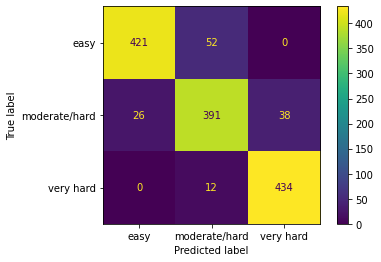

In [19]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])

cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [20]:
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': X_test_copy.iloc[i]['n/m'], 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)

for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'max': X_test_copy.iloc[i]['max'],
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'm': X_test_copy.iloc[i]['m'],
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

In [21]:
print(df_reg.shape[0])
print(df_reg.head(500))

506
         n      k    n/m   av.length     std.dev           y
0    180.0   72.0   2.00   61.922222   22.326036   16.009718
1    180.0   66.0   2.00   99.494446   18.036119   10.604177
2    140.0  121.0   2.00  337.457153  116.245293   15.652340
3    180.0   85.0   2.00   50.616665   29.712069   40.140587
4    120.0   63.0   2.00   61.208332   23.352213   11.710396
..     ...    ...    ...         ...         ...         ...
495   66.0   59.0   2.75  153.848480   56.141659   18.830084
496   72.0   56.0   4.50   52.763889   28.119709   25.066011
497  108.0   54.0   2.25  100.129631   18.947096   18.663025
498  180.0   72.0   4.50   97.599998   19.930214  161.925980
499  120.0   67.0  10.00   53.291668   29.580088  849.051575

[500 rows x 6 columns]


In [22]:
print(df_reg0.head())

       n     k     m    std.dev          y    max
0   20.0  19.0  10.0  42.628010   0.180378  189.0
1   80.0  53.0  40.0  24.449776   6.197287  100.0
2  140.0  65.0  70.0  19.030935   8.410722  146.0
3  140.0  60.0  70.0  19.174026  14.583659  158.0
4   20.0  17.0  10.0  24.547483   0.316743   92.0


In [23]:
print(df_reg2.head())

       n      k   av.length     std.dev      m        y
0   40.0   37.0   87.949997   48.465660   20.0  99999.0
1  180.0  112.0  101.466667   50.076527   90.0  99999.0
2  100.0   83.0   96.209999   47.907383   50.0  99999.0
3  160.0  133.0  652.887512  156.741806   80.0  99999.0
4  200.0  125.0  101.815002   50.574791  100.0  99999.0


In [24]:
for i in range(df_reg2.shape[0]):
  if(df_reg2.iloc[i]['y'] == 99999):
    df_reg2.loc[i, 'y'] = 4510

for i in range(df_reg.shape[0]):
  if(df_reg.iloc[i]['y'] == 99999):
    df_reg.loc[i, 'y'] = 4510

for i in range(df_reg0.shape[0]):
  if(df_reg0.iloc[i]['y'] == 99999):
    df_reg0.loc[i, 'y'] = 4510

print(df_reg['y'].max())
print(df_reg0['y'].max())
print(df_reg2['y'].max())
shuffled = df_reg.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

yy_final = []
predd_final = []

1663.807617
45.241497
4510.0


In [25]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
tmp = tmp.sample(frac = 1).reset_index()
print(tmp.head(60))
#y = np.log10(tmp['y']*10)+20
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

2842
2842
    index      n      k    n/m   av.length     std.dev     y
0    2155  180.0   82.0   6.00   51.916668   28.931219   233
1     577  180.0   66.0   2.00   99.494446   18.036119    10
2    1409  162.0   76.0   9.00   46.740742   28.289444   102
3    2047  110.0   95.0   2.75  458.200012  108.465515   209
4    2712  200.0   69.0   5.00  100.695000   18.155994  1130
5    2402  180.0   74.0   6.00   58.061111   23.979544   457
6    1678  120.0   93.0   5.00   99.625000   48.803493   133
7    1270  126.0   42.0   4.50   76.507935   13.070725    87
8     689  198.0   75.0   3.00   60.126263   24.167755    26
9    1754  126.0   71.0   9.00   49.515873   27.777327   142
10   2416  200.0   73.0   5.00   59.285000   22.394224   470
11    513  140.0   77.0   2.00   49.028572   28.646183     1
12   2321  126.0   95.0   4.50  103.984123   48.371731   418
13   2232  180.0   85.0   6.00   50.616665   29.712069   294
14    204  154.0   83.0   2.75   52.532467   29.403919    44
15   1714  144

In [26]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer="Adam")
    return model

In [27]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.9)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)
print(type(y_train))
for i in range(y_train.shape[0]):
  if(y_train.iloc[i] > 1000):
    y_train.iloc[i] = 1001
print(y_train.max())
X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

<class 'pandas.core.series.Series'>
1001
Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


40/40 [==============================] - 1s 2ms/step - loss: 2362864.5000
Epoch 2/300
40/40 [==============================] - 0s 2ms/step - loss: 1149158.2500
Epoch 3/300
40/40 [==============================] - 0s 2ms/step - loss: 493897.8750
Epoch 4/300
40/40 [==============================] - 0s 2ms/step - loss: 229614.0000
Epoch 5/300
40/40 [==============================] - 0s 2ms/step - loss: 150174.4844
Epoch 6/300
40/40 [==============================] - 0s 2ms/step - loss: 123383.8906
Epoch 7/300
40/40 [==============================] - 0s 2ms/step - loss: 108882.9609
Epoch 8/300
40/40 [==============================] - 0s 2ms/step - loss: 99857.2188
Epoch 9/300
40/40 [==============================] - 0s 2ms/step - loss: 88657.8125
Epoch 10/300
40/40 [==============================] - 0s 2ms/step - loss: 78101.5547
Epoch 11/300
40/40 [==============================] - 0s 2ms/step - loss: 67081.9453
Epoch 12/300
40/40 [==============================] - 0s 2ms/step - loss: 551

In [28]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

5/5 [==============================] - 0s 5ms/step
r_square score:  0.8632147231520703
RMSE:


118.26672529947356

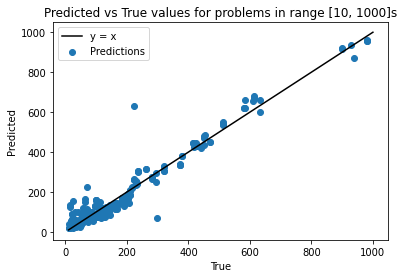

In [29]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  yy_final.append(yy[i])
  predd_final.append(predd[i])
  if(yy[i]>=10 and yy[i]<1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(10, 1000, 2000)
y = x
plt.title('Predicted vs True values for problems in range [10, 1000]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x, y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [44]:
shuffled = df_reg0.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [45]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
y = np.log(y + 100)
X_modified = tmp.drop(['y'], axis = 1)

4368
4368
       n     k     m    std.dev    max   y
0   60.0  53.0  24.0  57.714401  372.0   6
1   44.0  32.0  16.0  19.553080  136.0   5
2   36.0  31.0  12.0  24.033888  150.0   4
3   40.0  36.0  16.0  39.289970  197.0   3
4   36.0  29.0  16.0  19.543358  126.0   0
5   20.0  17.0   4.0  18.093033   78.0   0
6   36.0  30.0   6.0  31.650322  142.0   2
7   20.0  16.0   8.0  14.314052   94.0   0
8   36.0  32.0   8.0  32.828365  100.0   1
9   36.0  31.0   6.0  32.905876  143.0   9
10  20.0  17.0   8.0  20.396788   98.0   0
11  18.0  15.0   4.0  21.485973  144.0   0
12  22.0  20.0   8.0  21.919025  143.0   0
13  22.0  22.0   2.0  32.641171  100.0   1
14  20.0  16.0  10.0  20.287668   80.0   0
15  36.0  33.0  12.0  40.582741  230.0   5
16  18.0  18.0   3.0  52.844452  198.0   4
17  20.0  20.0  10.0  44.963608  199.0   0
18  54.0  36.0  24.0  14.242939  100.0   4
19  54.0  43.0  18.0  30.364845   98.0   5
20  18.0  17.0   4.0  15.575245  107.0   0
21  44.0  35.0  16.0  28.663418   97.0   4
2

In [46]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 10*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(12, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = 'relu'))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [47]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.9)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


# i in range(X_train.shape[0]):
 # if(y_train.iloc[i] > 10):
  #  y_train.iloc[i] = 11

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


62/62 [==============================] - 1s 4ms/step - loss: 21.9114
Epoch 2/300
62/62 [==============================] - 0s 2ms/step - loss: 15.7487
Epoch 3/300
62/62 [==============================] - 0s 2ms/step - loss: 6.5292
Epoch 4/300
62/62 [==============================] - 0s 2ms/step - loss: 2.5823
Epoch 5/300
62/62 [==============================] - 1s 9ms/step - loss: 1.6285
Epoch 6/300
62/62 [==============================] - 0s 5ms/step - loss: 1.2172
Epoch 7/300
62/62 [==============================] - 0s 2ms/step - loss: 1.0153
Epoch 8/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8937
Epoch 9/300
62/62 [==============================] - 0s 2ms/step - loss: 0.8223
Epoch 10/300
62/62 [==============================] - 0s 2ms/step - loss: 0.7233
Epoch 11/300
62/62 [==============================] - 0s 2ms/step - loss: 0.6553
Epoch 12/300
62/62 [==============================] - 0s 2ms/step - loss: 0.6075
Epoch 13/300
62/62 [===========================

7/7 [==============================] - 0s 3ms/step
r_square score:  0.9839295836539805
RMSE:
1.3293697965154474


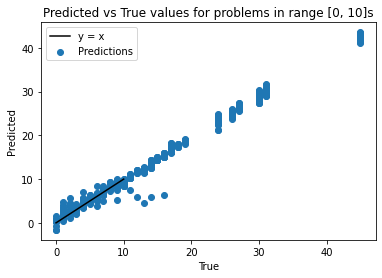

In [48]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10
#print(yy)
yy = np.exp(yy) - 100
predd = np.exp(predd) - 100
print("r_square score: ", r2_score(yy, predd))


from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
print(sqrt(mean_squared_error(yy, predd)))

x = np.linspace(0, 10, 100)
y = x
plt.title('Predicted vs True values for problems in range [0, 10]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy, predd)
plt.legend(['y = x', 'Predictions'])

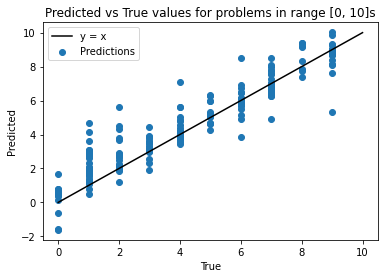

In [49]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  yy_final.append(yy[i])
  predd_final.append(predd[i])
  if(yy[i]<10):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(0, 10, 100)
y = x
plt.title('Predicted vs True values for problems in range [0, 10]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [36]:
shuffled = df_reg2.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [37]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

52398
52398
        n      k   av.length     std.dev      m     y
0   140.0   68.0   98.142860   19.779930   14.0  4510
1   198.0   75.0   59.843433   23.622253   18.0  4510
2   160.0  100.0  102.606247   46.929787   80.0  4510
3   198.0  172.0  792.474731  216.066925   66.0  4510
4   126.0  108.0  491.087311  124.145454   28.0  4510
5   126.0  104.0  309.650787  108.644478   28.0  4510
6    90.0   80.0  216.866669   77.720795   10.0  4510
7   198.0  166.0  490.202026  171.781097   66.0  4510
8    90.0   77.0  362.888885   98.232292   10.0  4510
9   144.0   65.0   61.625000   22.876644   16.0  1153
10  160.0   69.0   62.643749   23.113699   16.0   228
11  180.0  150.0  449.022217  154.397949   20.0  4510
12  180.0  154.0  706.877808  175.294418   90.0  4510
13   72.0   65.0  277.444458   86.164093    8.0   549
14   80.0   66.0  191.862503   71.323082    8.0  1043
15  140.0  128.0  592.521423  146.894257   70.0     1
16  180.0  155.0  718.166687  176.978607   20.0  4510
17  132.0   45.0

In [38]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(16, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(16, activation = 'relu'))

    model.add(Dense(4, activation = 'relu'))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [39]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.9)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=60, batch_size=128, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


369/369 [==============================] - 1s 2ms/step - loss: 317568.9062
Epoch 2/60
369/369 [==============================] - 1s 2ms/step - loss: 109512.0234
Epoch 3/60
369/369 [==============================] - 1s 2ms/step - loss: 81793.7734
Epoch 4/60
369/369 [==============================] - 1s 2ms/step - loss: 65285.4727
Epoch 5/60
369/369 [==============================] - 1s 2ms/step - loss: 53514.2109
Epoch 6/60
369/369 [==============================] - 1s 2ms/step - loss: 42658.3398
Epoch 7/60
369/369 [==============================] - 1s 2ms/step - loss: 35389.7227
Epoch 8/60
369/369 [==============================] - 1s 2ms/step - loss: 33394.2305
Epoch 9/60
369/369 [==============================] - 1s 2ms/step - loss: 30953.2461
Epoch 10/60
369/369 [==============================] - 1s 2ms/step - loss: 28215.0508
Epoch 11/60
369/369 [==============================] - 1s 2ms/step - loss: 26037.0449
Epoch 12/60
369/369 [==============================] - 1s 2ms/step - los

In [40]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

41/41 [==============================] - 0s 2ms/step
r_square score:  0.9831533434079978
RMSE:


136.61050291274995

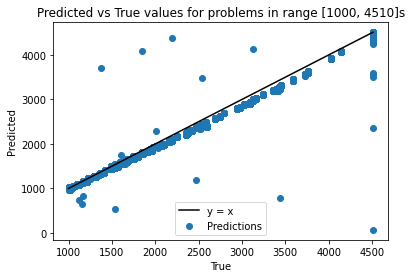

In [41]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  yy_final.append(yy[i])
  predd_final.append(predd[i])
  if(yy[i]>1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(1000, 4510, 2000)
y = x

plt.title('Predicted vs True values for problems in range [1000, 4510]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [42]:
print("r_square score: ", r2_score(yy_final, predd_final))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(yy_final)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(predd_final)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

r_square score:  0.9861557601496254
RMSE:


130.65701142716443

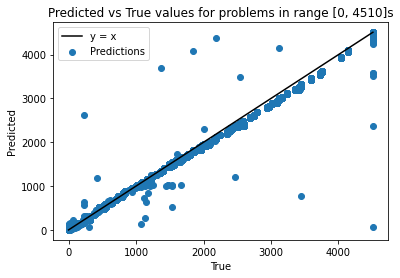

In [43]:
x = np.linspace(0, 4510, 2000)
y = x

plt.title('Predicted vs True values for problems in range [0, 4510]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_final, predd_final)
plt.legend(['y = x', 'Predictions'])